<a href="https://colab.research.google.com/github/AntoninaKOR/RL/blob/main/RL%2BPacman_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Downloading and importing libs

In [ ]:
!apt-get install swig
!pip install Image
!pip install autorom
!pip install shimmy
!pip install 'gymnasium[atari]'
#!pip install "gym[atari, accept-rom-license]"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 49 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (813 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 123623 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubunt

In [ ]:
import gymnasium as gym
import numpy as np
import ale_py
import shimmy
from torch.distributions import Categorical
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

### Intro
There is a **REINFORCE** algorithm with policy function with based on **Alexnet** (but with other sizes of out_channels and without one conv layer). The algorithm works on MsPacman environment from Gymnasium lib.

It can be intresting to check REINFORCE on more complex environment.

### Task

The playing MsPacman consists of two parts:
* avoiding ghosts
* getting points
At this notebook we will focus on getting points, because avoiding ghosts is more complex task.

So the **main task** is teach the regularly stable get more then 200 points.


#About env

Info about environment: https://ale.farama.org/environments/ms_pacman/

There is how env looks:

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Initial observation:


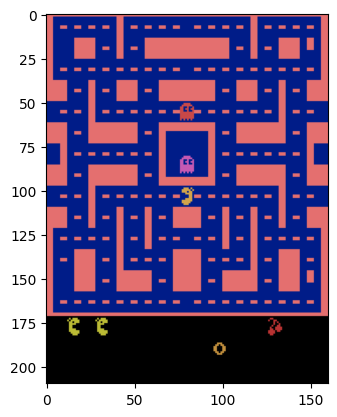

In [ ]:
env = gym.make("ALE/MsPacman-v5",  render_mode="rgb_array", obs_type="grayscale")
env.reset()
print("Initial observation:")
plt.imshow(env.render())

In [ ]:
new_s, reward, done, truncated, d = env.step(0)
print("At each step it returns:")

print("new observation code:", new_s)
print("reward:", reward)
print("is game over?:", done)
print('d:', d)

At each step it returns:
new observation code: [[  0   0   0 ...   0   0   0]
 [146 146 146 ... 146 146 146]
 [146 146 146 ... 146 146 146]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
reward: 0.0
is game over?: False
d: {'lives': 3, 'episode_frame_number': 4, 'frame_number': 4}


Let's look on more information about game spase.

Unique values:  0 32 90 110 132 146 150 167 172


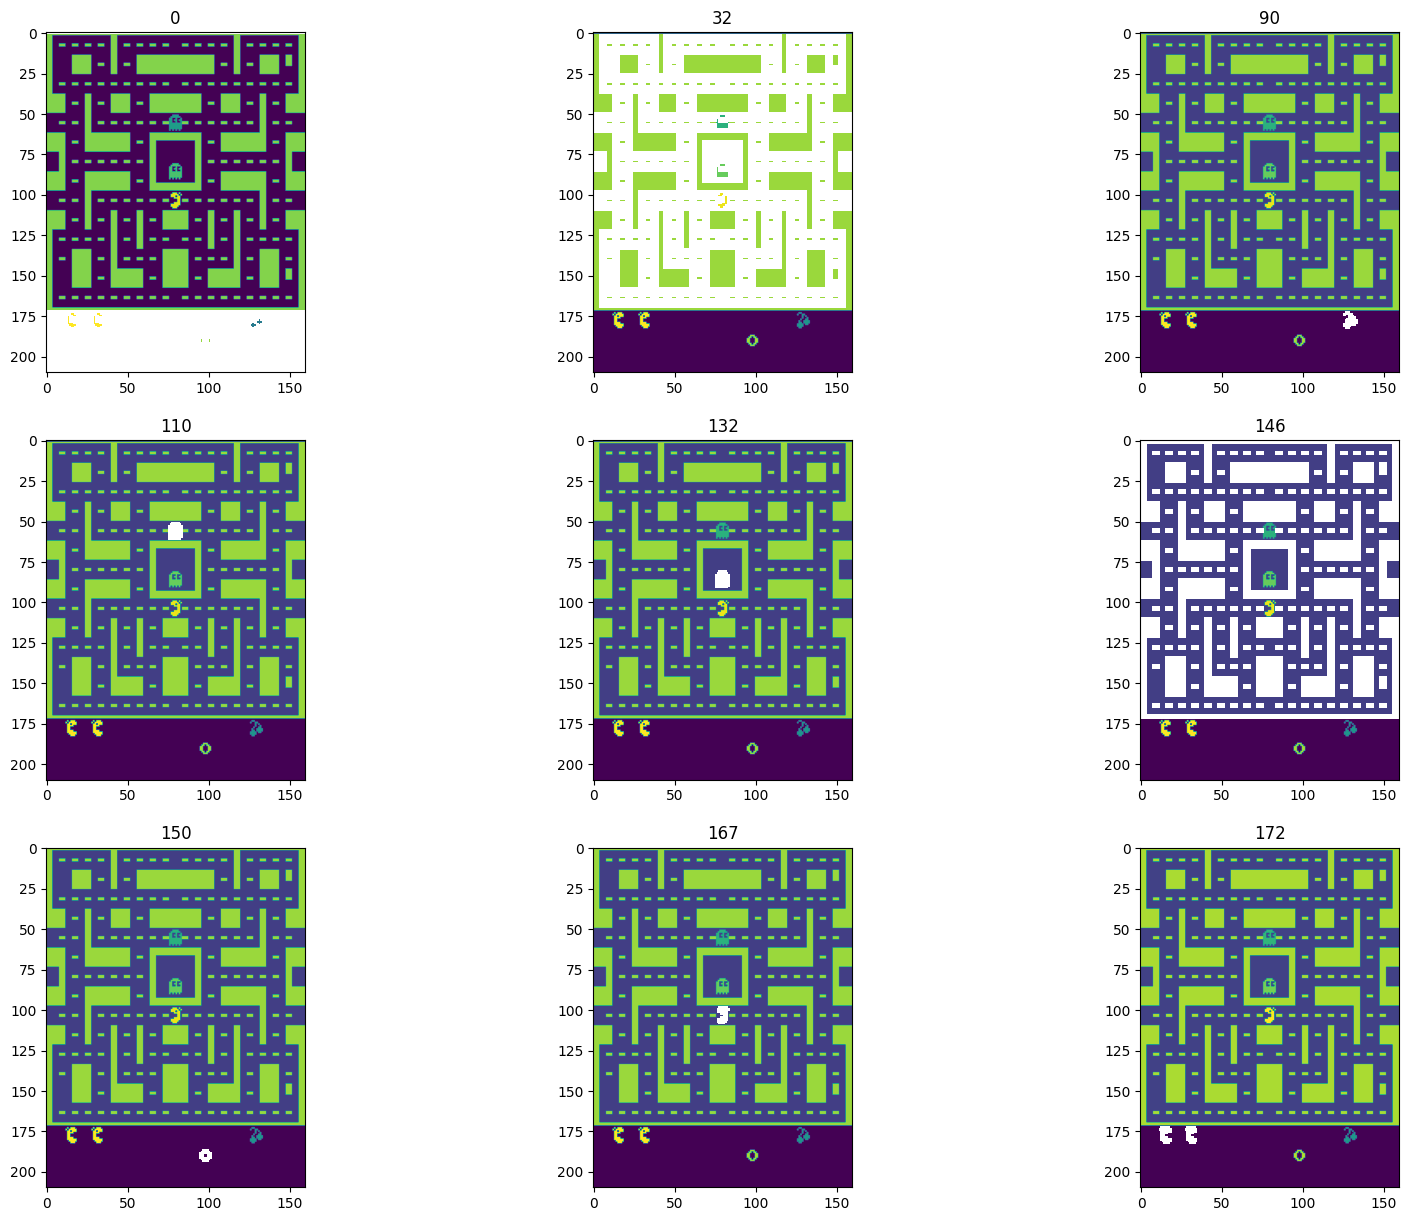

In [ ]:
import numpy.ma as ma
state = env.reset()
uniq_vals = np.unique(state[0])
print('Unique values: ', *uniq_vals)
f, ax = plt.subplots(len(uniq_vals)//3 + (len(uniq_vals)%3!=0),3, figsize=(20, 15))
for i, val in enumerate(uniq_vals):
  ax[i//3][i%3].set_title(val)
  ax[i//3][i%3].imshow(ma.masked_array(state[0], mask = state[0]==val))

Notices:
This number correlate to:
*   0 --- black
*   32 --- color of floor
*   90 --- cherry
*   110 and 132 --- ghosts
*   146 --- walls of labirint and points
*   150 --- score
*   167 --- pacman
*   172 --- lives



We want to limit the space, that environment returns, to the game area.

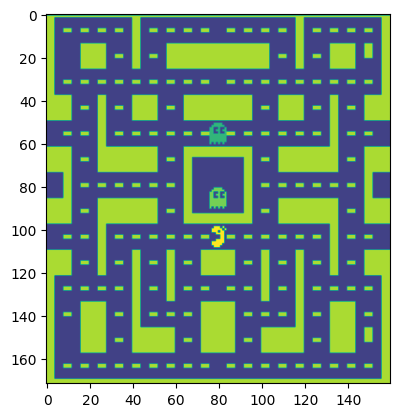

In [ ]:
plt.imshow(state[0][:172,:])

##Assumptions about env:
* There is a lot of reward, so model can overfit rapidly.
* Wall have same number as points, so the model can try to eat walls.

##About actions

We also limit actions witch pacman can do to clarify task for the model.



All moves are:


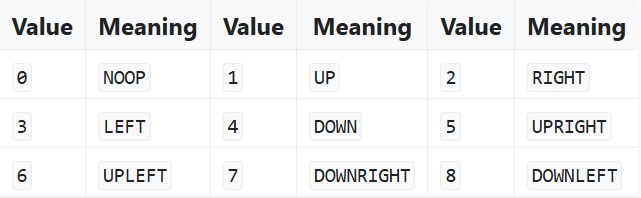


But the model will use only action from 0 to 4, because other actions are combinations of chosen actions.

#Realisation

##Algorithm
We use algorithm from the book "Foundations of Deep Reinforcement Learning: Theory and Practice in Python" (Addison-Wesley Data & Analytics Series).

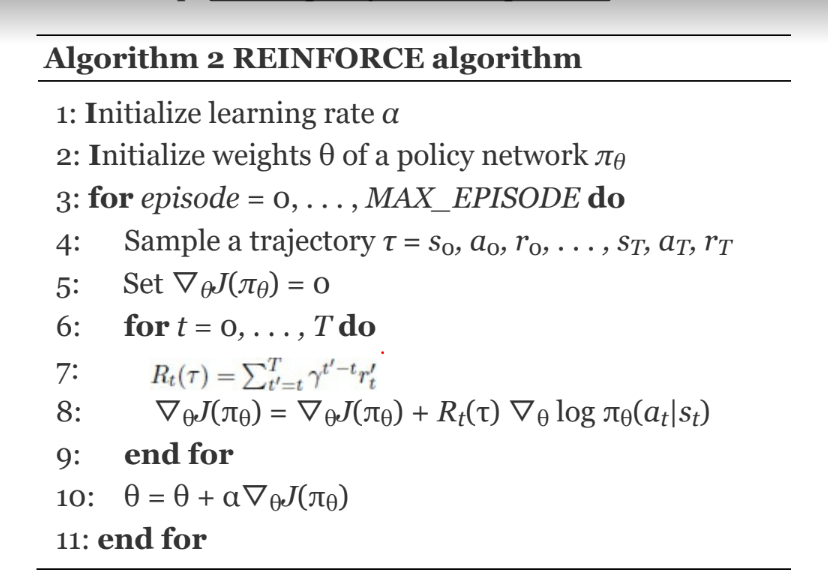

##Initialization

In [ ]:
#Policy function
class Pi(nn.Module):
  def __init__(self, in_dim, out_dim, dropout: float = 0.5):
    super(Pi, self).__init__()
    layers = [ # input (1, 172, 160)
               nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3), #  (6, 170, 158)
               nn.ReLU(inplace=True),
               nn.MaxPool2d(kernel_size=2), # ( 6, 104, 79)

               nn.Conv2d(6, 18, kernel_size=5, padding=2), #(18, 104, 79)
               nn.ReLU(inplace=True),
               nn.MaxPool2d(kernel_size=3, stride=2), #(18, 51, 39)

               nn.Conv2d(18, 64, kernel_size=3, padding=1), #(64, 51, 39)
               nn.ReLU(inplace=True),
               nn.MaxPool2d(kernel_size=3, stride=2), #(64, 24, 18)

               nn.AdaptiveAvgPool2d((6, 6)),

               nn.Flatten(0),

               nn.Dropout(p=dropout),
               nn.Linear(64 * 6 * 6, 1152),
               nn.ReLU(inplace=True),

               nn.Dropout(p=dropout),
               nn.Linear(1152, 64),
               nn.Linear(64,out_features = 5)
               ]

    self.model = nn.Sequential(*layers)
    self.onpolicy_reset()
    self.train()

  def onpolicy_reset(self):
    self.log_probs = []
    self.rewards = []

  def forward(self, x):
    pdparam = self.model(x)
    return pdparam

  def act(self, state):
    x = torch.from_numpy(np.expand_dims(state,0)).to(torch.float32)
    pdparam = self.forward(x)
    pd = Categorical(logits =pdparam)
    action = pd.sample()
    log_prob = pd.log_prob(action )
    self.log_probs.append(log_prob.item())
    return action.item()


In [ ]:
#training function
def train(pi, gamma,  optimizer):
  # T is len of trajectories
  T = len(pi.rewards)
  r = np.empty(T)
  R = 0.0
  # we use reversed becouse  R_t = R_{t-1}*gamma + r_t
  for t in reversed(range(T)):
    R = pi.rewards[t] + gamma * R
    r[t] = R
  r = torch.tensor(r, requires_grad=True)
  log_probs = pi.log_probs
  loss = torch.tensor(log_probs, requires_grad=True) * r
  loss = (-1)*torch.sum(loss)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss

##Training

In [ ]:
from IPython import display
from tqdm import trange, tqdm
display.clear_output(wait=True)
MAX_STEP=2_000
N=4_000
GAMMA=0.1
losses=[]
rewards=[]
steps=[]
n_states = env.observation_space.shape[0]*env.observation_space.shape[1] *255
n_actions = env.action_space.n
pi = Pi(n_states, n_actions)
optimizer = optim.Adam(pi.parameters(), lr = 0.001)
loop = trange(N, leave=True)
for epi in loop:
  state = env.reset()
  rew=0
  t=0
  while t<MAX_STEP:
    t+=1
    action = pi.act(state[0][:172,:]/255.)
    new_s, r, terminated, truncated, _ = env.step(action)
    pi.rewards.append(r/1000)
    rew+=r/1000
    env.render()
    if terminated or truncated:
      break
  loss = train(pi, GAMMA,  optimizer)
  losses.append(loss)
  rewards.append(rew)
  steps.append(t+1)
  total_reward = sum(pi.rewards)
  solved = total_reward > 0
  pi.onpolicy_reset()
  if epi%100==0:
    tqdm.write(f'Episode {epi}, loss: {loss}, count of steps:{t+1}, total_reward:{total_reward}')

  0%|          | 1/4000 [00:03<4:20:44,  3.91s/it]

Episode 0, loss: 0.3560197950618991, count of steps:380, total_reward:0.20000000000000004


  3%|▎         | 101/4000 [06:49<5:19:23,  4.92s/it]

Episode 100, loss: 0.8361905507062437, count of steps:790, total_reward:0.4700000000000002


  5%|▌         | 201/4000 [13:32<4:06:10,  3.89s/it]

Episode 200, loss: 0.483675640212321, count of steps:450, total_reward:0.2700000000000001


  8%|▊         | 301/4000 [20:07<4:19:04,  4.20s/it]

Episode 300, loss: 0.547757144892246, count of steps:536, total_reward:0.3100000000000001


 10%|█         | 401/4000 [27:16<3:59:07,  3.99s/it]

Episode 400, loss: 0.36162278236464424, count of steps:406, total_reward:0.20000000000000004


 13%|█▎        | 501/4000 [34:05<4:03:26,  4.17s/it]

Episode 500, loss: 0.5692901591993785, count of steps:592, total_reward:0.3200000000000001


 15%|█▌        | 601/4000 [40:45<3:33:46,  3.77s/it]

Episode 600, loss: 0.4595672787358796, count of steps:482, total_reward:0.26000000000000006


 18%|█▊        | 701/4000 [47:35<3:56:30,  4.30s/it]

Episode 700, loss: 0.36460426845719063, count of steps:432, total_reward:0.21000000000000005


 20%|██        | 801/4000 [54:50<4:02:28,  4.55s/it]

Episode 800, loss: 0.5155410750770636, count of steps:528, total_reward:0.2900000000000001


 23%|██▎       | 901/4000 [1:01:57<3:46:05,  4.38s/it]

Episode 900, loss: 0.38835067570015513, count of steps:484, total_reward:0.22000000000000006


 25%|██▌       | 1001/4000 [1:08:59<3:29:02,  4.18s/it]

Episode 1000, loss: 0.40550845299002997, count of steps:582, total_reward:0.23000000000000007


 28%|██▊       | 1101/4000 [1:15:55<3:17:59,  4.10s/it]

Episode 1100, loss: 0.2264809111016881, count of steps:488, total_reward:0.12999999999999998


 30%|███       | 1201/4000 [1:22:51<3:01:58,  3.90s/it]

Episode 1200, loss: 0.5056396815426929, count of steps:428, total_reward:0.2800000000000001


 33%|███▎      | 1301/4000 [1:29:44<2:56:57,  3.93s/it]

Episode 1300, loss: 0.4427106104842566, count of steps:478, total_reward:0.25000000000000006


 35%|███▌      | 1401/4000 [1:36:48<3:36:25,  5.00s/it]

Episode 1400, loss: 0.9874157273656649, count of steps:800, total_reward:0.55


 38%|███▊      | 1501/4000 [1:43:47<3:12:57,  4.63s/it]

Episode 1500, loss: 0.39354491226248234, count of steps:498, total_reward:0.22000000000000006


 40%|████      | 1601/4000 [1:50:42<2:38:10,  3.96s/it]

Episode 1600, loss: 0.21411063047047701, count of steps:310, total_reward:0.11999999999999998


 43%|████▎     | 1701/4000 [1:57:34<2:31:06,  3.94s/it]

Episode 1700, loss: 0.3970001320549484, count of steps:514, total_reward:0.22000000000000006


 45%|████▌     | 1801/4000 [2:04:37<2:35:29,  4.24s/it]

Episode 1800, loss: 0.40576807202274723, count of steps:558, total_reward:0.23000000000000007


 48%|████▊     | 1901/4000 [2:11:40<2:14:16,  3.84s/it]

Episode 1900, loss: 0.3894769093204788, count of steps:470, total_reward:0.22000000000000006


 50%|█████     | 2001/4000 [2:18:45<2:29:08,  4.48s/it]

Episode 2000, loss: 0.3743052109452434, count of steps:416, total_reward:0.21000000000000005


 53%|█████▎    | 2101/4000 [2:25:36<1:51:52,  3.53s/it]

Episode 2100, loss: 0.4093605226946847, count of steps:410, total_reward:0.23000000000000007


 55%|█████▌    | 2201/4000 [2:32:32<1:52:55,  3.77s/it]

Episode 2200, loss: 0.483773769355371, count of steps:516, total_reward:0.2700000000000001


 58%|█████▊    | 2301/4000 [2:39:15<1:55:35,  4.08s/it]

Episode 2300, loss: 0.5077636347591455, count of steps:496, total_reward:0.2800000000000001


 60%|██████    | 2401/4000 [2:45:44<1:45:35,  3.96s/it]

Episode 2400, loss: 0.3950347702935373, count of steps:550, total_reward:0.22000000000000006


 63%|██████▎   | 2501/4000 [2:52:29<1:41:44,  4.07s/it]

Episode 2500, loss: 0.32370543512830763, count of steps:504, total_reward:0.18000000000000002


 65%|██████▌   | 2601/4000 [2:59:20<1:31:11,  3.91s/it]

Episode 2600, loss: 0.228444363269237, count of steps:448, total_reward:0.12999999999999998


 68%|██████▊   | 2701/4000 [3:05:56<1:41:38,  4.69s/it]

Episode 2700, loss: 0.7134463225747851, count of steps:754, total_reward:0.4000000000000002


 70%|███████   | 2801/4000 [3:12:35<1:13:40,  3.69s/it]

Episode 2800, loss: 0.40610893734100434, count of steps:508, total_reward:0.23000000000000007


 73%|███████▎  | 2901/4000 [3:19:37<1:37:33,  5.33s/it]

Episode 2900, loss: 1.1006893872257595, count of steps:906, total_reward:0.6200000000000001


 75%|███████▌  | 3001/4000 [3:26:33<1:08:34,  4.12s/it]

Episode 3000, loss: 0.3034899825255434, count of steps:458, total_reward:0.17


 78%|███████▊  | 3101/4000 [3:33:13<1:05:51,  4.40s/it]

Episode 3100, loss: 0.544586270086967, count of steps:724, total_reward:0.3100000000000001


 80%|████████  | 3201/4000 [3:40:00<54:17,  4.08s/it]

Episode 3200, loss: 0.49609158249052154, count of steps:534, total_reward:0.2800000000000001


 83%|████████▎ | 3301/4000 [3:47:05<50:30,  4.34s/it]

Episode 3300, loss: 0.4049859680022902, count of steps:462, total_reward:0.23000000000000007


 85%|████████▌ | 3401/4000 [3:54:02<36:44,  3.68s/it]

Episode 3400, loss: 0.29886539419716357, count of steps:410, total_reward:0.17


 88%|████████▊ | 3501/4000 [4:00:47<35:06,  4.22s/it]

Episode 3500, loss: 0.502268495750607, count of steps:620, total_reward:0.2800000000000001


 90%|█████████ | 3601/4000 [4:07:34<30:21,  4.56s/it]

Episode 3600, loss: 0.729044970778543, count of steps:734, total_reward:0.4100000000000002


 93%|█████████▎| 3701/4000 [4:14:31<21:40,  4.35s/it]

Episode 3700, loss: 0.4299866479469514, count of steps:460, total_reward:0.24000000000000007


 95%|█████████▌| 3801/4000 [4:20:56<13:22,  4.03s/it]

Episode 3800, loss: 1.0294521998043442, count of steps:638, total_reward:0.5700000000000001


 98%|█████████▊| 3901/4000 [4:28:23<08:44,  5.30s/it]

Episode 3900, loss: 0.3550142105416113, count of steps:526, total_reward:0.20000000000000004


100%|██████████| 4000/4000 [4:35:16<00:00,  4.13s/it]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


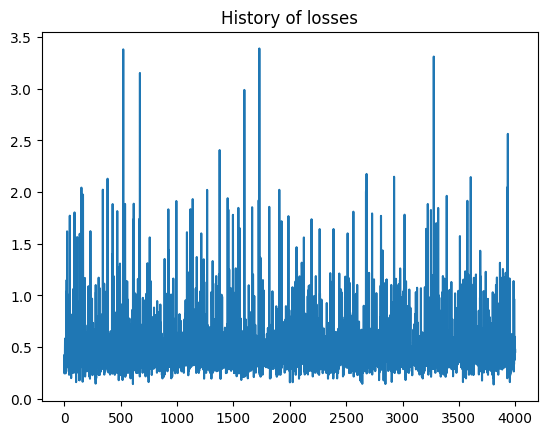

In [ ]:
plt.plot(torch.stack(losses).detach().numpy())
plt.title("History of losses")
plt.show()

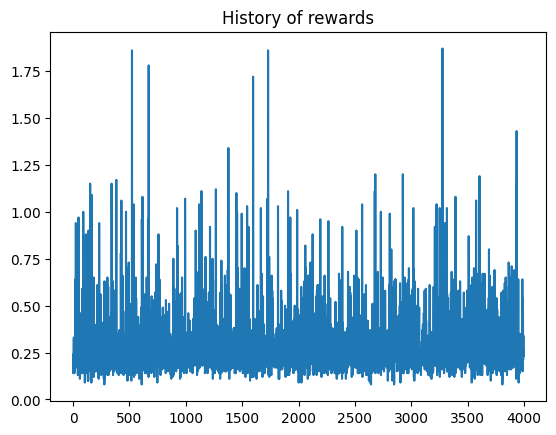

In [ ]:
plt.plot(rewards)
plt.title("History of rewards")
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


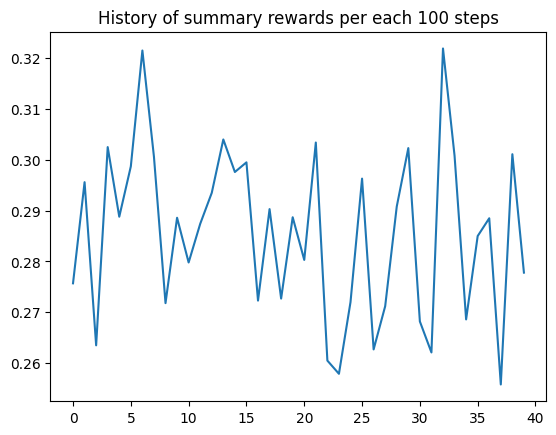

In [ ]:
avg_rew =[]
for i in range(99, len(rewards), 100):
  x=0
  for j in range(100):
    x+= rewards[i-j]
  avg_rew.append(x/100.)

plt.plot(avg_rew)
plt.title("History of summary rewards per each 100 steps")
plt.show()

rewards/steps can be more informative because its growing with same reward is indicator that the model do not move randomly. And too good rewards/steps can be indicator that model is overfitted.

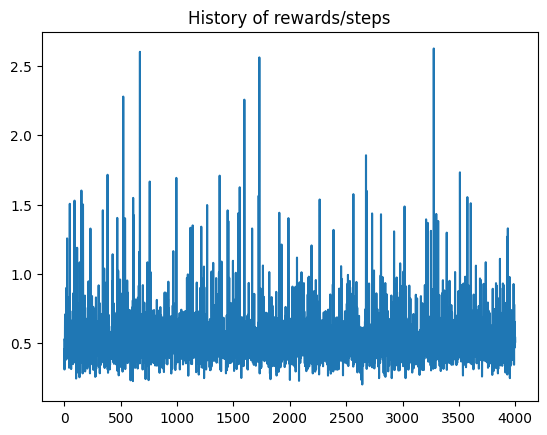

In [ ]:
plt.plot(np.array(rewards)/np.array(steps)*1000)
plt.title("History of rewards/steps")
plt.show()

Now we can look how fitted model moves online.

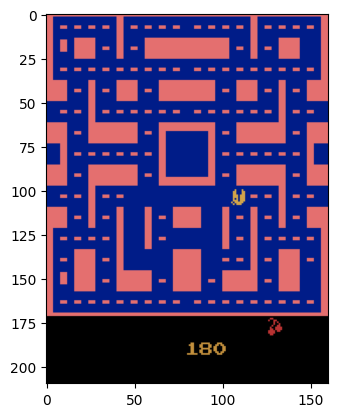

In [ ]:
state = env.reset()
plt.imshow(state[0])
for t in range(1000):
  action = pi.act(state[0][:172,:]/255)
  new_s, r, terminated, truncated, _ = env.step(action)
  plt.imshow(env.render())
  display.display(plt.gcf())
  display.clear_output(wait=True)
  if terminated or truncated:
    break

#Conclusions
**Positive aspects**:
* The main task is complited. When I try to not use convs layers, the model gets only about 70 points, but now it regularly more then 200.
* The model have learn how moves through game's labyrinth. At first times it have been overfitted and it cannot escape from corners.


**Negative aspects**:
* The model never learned to avoid ghosts, so it often dies and is unable to fully explore the environment.
* The model cannot discover because the model die fast.
* The model can overfit bacause we always start from one point.


**Ideas**:
*  First problem can be solved by more fitting and using other architecture for policy.
* Also negative reward for meeting with ghosts can help against first problem.
* Two last problems can be solved by making  100 random moves without learning. So, the model would start from new points.
* Maybe we should make two models. One will learn to avoid ghosts, the other will maximize the reward. Together they will choose the most profitable action that is not their pacman.
* The playing field is symmetrical about the middle, so it may be sufficient to train the model on half of the image and then retrain it on the other.